In [1]:
# This notebook trains LSTM model on the preprocessed forecasted data

# forecast_features= [
#     "forecast_alberta_internal_load", 
#     "rolling_30day_avg_price", 
#     "solar_generation", 
#     "wind_generation", 
#     "temp_calgary", 
#     "temp_edmonton", 
#     "temp_fortmc", 
#     "ws_calgary",
#     "ws_edmonton", 
#     "ws_fortmc",
#     "datetime_", 
#     "hour_of_day", 
#     "day_of_week", 
#     "day_of_month", 
#     "week_of_month", 
#     "month", 
#     "year", 
#     "is_winter" 
# ]



# NVIDIA-SMI 535.183.01 
# CUDA Version: 10.1
# CUDNN Version: 
    #define CUDNN_MAJOR 7
    #define CUDNN_MINOR 6
    #define CUDNN_PATCHLEVEL 5
# Tensorflow Version: 2.2.0
# Python Version: 3.8.10

#### Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Suppress pandas performance warnings
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
# check tf version
print('TensorFlow version:', tf.__version__)

#  Check if TensorFlow can access GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("No GPU found, using CPU instead.")

TensorFlow version: 2.2.0
TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-09 14:59:59.936798: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-09 14:59:59.983230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 14:59:59.983526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 37.33GiB/s
2025-03-09 14:59:59.984013: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-09 14:59:59.988565: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-09 14:59:59.993016: I tensorflow/stream_executor/platform

#### Data Loading

In [30]:
# Load the data
# df2019 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2019/merged_df_2019_cleaned.csv')
df2020 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2020/merged_df_2020_cleaned.csv')
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [31]:
# Concatenate the data
# df2019
df = pd.concat([df2020, df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [32]:
df.shape

(43863, 69)

In [33]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2020-01-01 00:00:00,9467.0,9688.0,30.24,28.79,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
1,2020-01-01 01:00:00,9361.0,9541.0,29.43,28.19,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
2,2020-01-01 02:00:00,9286.0,9410.0,29.66,31.19,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
3,2020-01-01 03:00:00,9209.0,9328.0,28.19,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
4,2020-01-01 04:00:00,9195.0,9319.0,31.17,28.19,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1,28.19,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9209.0,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0


In [34]:
# remove actual AIL
df.drop(['alberta_internal_load'], inplace=True, axis=1)

# remove forecast_pool_price
df.drop(['forecast_pool_price'], inplace=True, axis=1)

In [35]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False)

alberta_internal_load_lag_24      0
month                             0
pool_price_lag_12                 0
pool_price_lag_11                 0
pool_price_lag_10                 0
pool_price_lag_9                  0
pool_price_lag_8                  0
pool_price_lag_7                  0
pool_price_lag_6                  0
pool_price_lag_5                  0
pool_price_lag_4                  0
pool_price_lag_3                  0
pool_price_lag_2                  0
pool_price_lag_1                  0
is_winter                         0
year                              0
week_of_month                     0
pool_price_lag_14                 0
day_of_month                      0
day_of_week                       0
hour_of_day                       0
ws_fortmc                         0
ws_edmonton                       0
ws_calgary                        0
wind_generation                   0
temp_fortmc                       0
temp_edmonton                     0
temp_calgary                

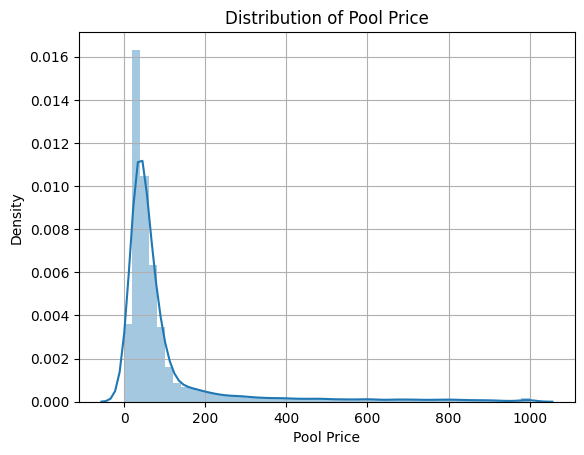

In [36]:
# Create a distribution plot of the 'pool_price' column
sns.distplot(df['pool_price'], hist=True, kde=True)

# Add labels and title
plt.xlabel('Pool Price')
plt.ylabel('Density')
plt.title('Distribution of Pool Price')

# Show the plot
plt.grid()
plt.show()

In [37]:
# data filter to remove outliers
# df = df[df['pool_price'] <=200]

#### Train-Test split

In [38]:
df.head()

,datetime_,forecast_alberta_internal_load,pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2020-01-01 00:00:00,9688.0,30.24,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
1,2020-01-01 01:00:00,9541.0,29.43,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
2,2020-01-01 02:00:00,9410.0,29.66,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
3,2020-01-01 03:00:00,9328.0,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
4,2020-01-01 04:00:00,9319.0,31.17,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1,28.19,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9209.0,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0


In [39]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-07-01']
test_data = df[df['datetime_'] >= '2024-07-01']

# Define independent variables (features) and target variable
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']
# Display the shapes of the training data
print(X_train.shape, y_train.shape)

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']
# Display the shapes of the test data
print(X_test.shape, y_test.shape)

(39444, 65) (39444,)
(4419, 65) (4419,)


In [40]:
#Converting dataframe to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [41]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
#Reshaping the train and test data to pass into the LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, int(X_train.shape[1])))
X_test = X_test.reshape((X_test.shape[0], 1, int(X_test.shape[1])))

In [43]:
# Display the shapes of the training data
X_train.shape

(39444, 1, 65)

#### Model Training

In [44]:
#Baseline LSTM model
model = tf.keras.Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))

# Compile the model
model.compile(optimizer='adam', loss='mae')

In [45]:
# display architecture of model shape of different layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               99328     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 109,697
Trainable params: 109,697
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/20
247/247 - 2s - loss: 73.0861 - val_loss: 42.6718
Epoch 2/20
247/247 - 2s - loss: 38.1497 - val_loss: 40.7918
Epoch 3/20
247/247 - 2s - loss: 32.9944 - val_loss: 38.1933
Epoch 4/20
247/247 - 2s - loss: 31.6892 - val_loss: 37.7132
Epoch 5/20
247/247 - 2s - loss: 30.8954 - val_loss: 35.9477
Epoch 6/20
247/247 - 2s - loss: 30.5392 - val_loss: 37.0913
Epoch 7/20
247/247 - 1s - loss: 30.0191 - val_loss: 35.5638
Epoch 8/20
247/247 - 1s - loss: 29.6874 - val_loss: 36.2530
Epoch 9/20
247/247 - 1s - loss: 29.3578 - val_loss: 35.6018
Epoch 10/20
247/247 - 1s - loss: 29.0196 - val_loss: 36.5446
Epoch 11/20
247/247 - 1s - loss: 28.7669 - val_loss: 36.9717
Epoch 12/20
247/247 - 1s - loss: 28.5280 - val_loss: 38.0311
Epoch 13/20
247/247 - 1s - loss: 28.2341 - val_loss: 37.3540
Epoch 14/20
247/247 - 1s - loss: 27.9632 - val_loss: 37.2855
Epoch 15/20
247/247 - 2s - loss: 27.7788 - val_loss: 35.4750
Epoch 16/20
247/247 - 1s - loss: 27.5145 - val_loss: 36.0851
Epoch 17/20
247/247 - 1s - loss: 

#### Model Performance Check

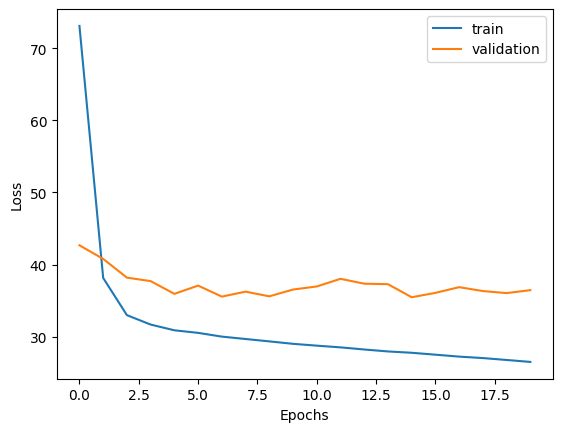

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(-1, 1)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('y_train shape:', y_train.shape)
print(f'Mean Absolute Error on the train set : {mae}')
print(f"R² Score train set: {r2}")

y_train shape: (39444,)
Mean Absolute Error on the train set : 28.22746531385641
R² Score train set: 0.8228498980188571


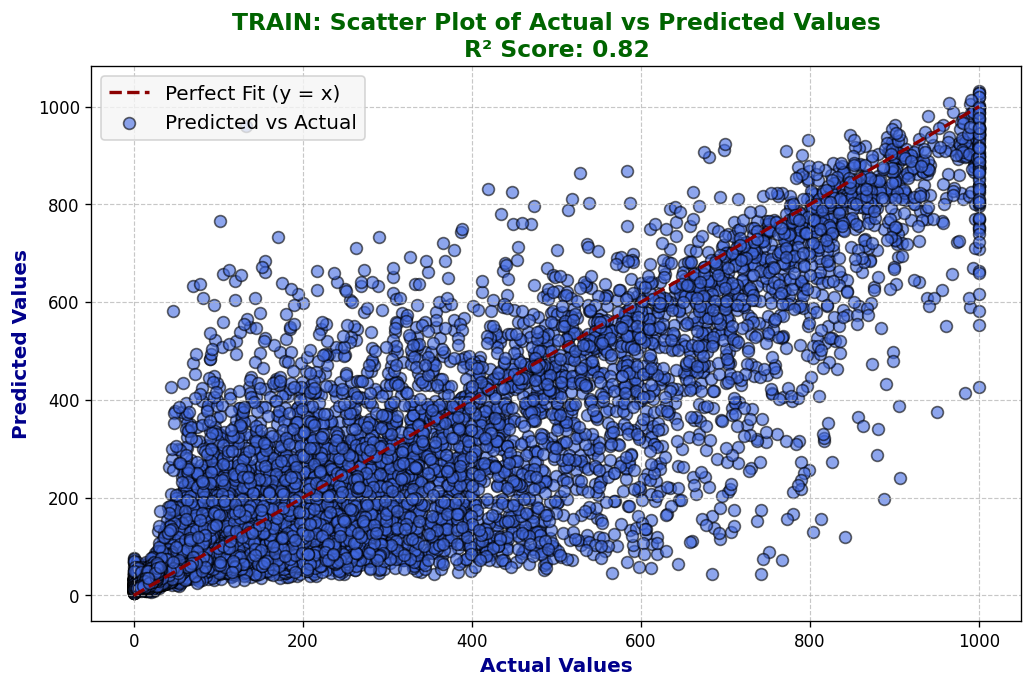

In [49]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_train, y_train_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TRAIN: Scatter Plot of Actual vs Predicted Values\nR² Score: {r2:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


In [50]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(-1, 1)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('y_test_pred shape:', y_test_pred.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

y_test_pred shape: (4419, 1)
Mean Absolute Error on the test set : 42.34261987862691
R² Score test set: 0.6884359003449447


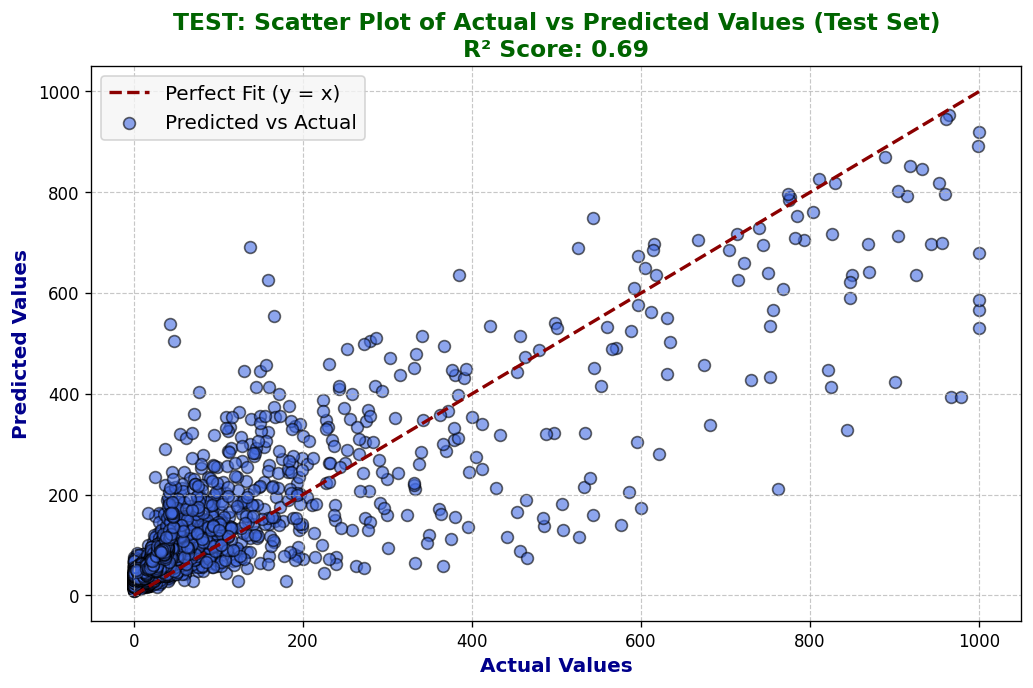

In [51]:
# Create a scatter plot for test data with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_test, y_test_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TEST: Scatter Plot of Actual vs Predicted Values (Test Set)\nR² Score: {r2:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


In [52]:
# Create a dataframe of the actual and predicted values
results_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred.flatten()})
results_df.head()

,y_test,y_test_pred
0,14.69,27.407776
1,16.23,27.392450
2,15.77,26.284155
3,13.85,26.956232
4,13.58,27.408064


In [53]:
terget_df = results_df[results_df['y_test'] <= 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (4203, 2)
Mean Absolute Error on the test set : 36.883849965072145
R² Score test set: -1.5309704196081233


In [54]:
terget_df = results_df[results_df['y_test'] > 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (216, 2)
Mean Absolute Error on the test set : 148.56118444654678
R² Score test set: 0.3552200484221435


In [ ]:
# run scripts and extract forecasted 24 hours data
# engineer the remaining features
# scale the data
# make predictions

: 